# Post Quantum Cryptography

![alt text](images/quantum_intro.webp)

## Importing the required packages 

Please run this code below to have all the required packages to start the lab!

In [2]:
import math
from math import gcd, log, floor
import random
from sympy import isprime, legendre_symbol, gcd
import numpy as np
import time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit import QuantumRegister, ClassicalRegister
from fractions import Fraction

# I) What is RSA ?

## a) Math Introduction (base of the algorithm -> Factorisation of prime numbers)


First of all let's introduce some math aspects and especially prime numbers. 
For those who don't know what a prime number is, it's an integer greater than 1 that has only two divisors: 1 and itself. 
Examples: 2, 3, 5, 7, 11, 13...
Let's now speak about prime factorisation : Every integer can be written as a unique product of prime numbers. This comes from the Fundamental Theorem of Arithmetic which states that "Every integer greater than 1 is either a prime itself or can be written uniquely (up to the order of factors) as a product of prime numbers."
Some key examples : 28 = 2 × 2 × 7 = 2² × 7 or 91 = 7 × 13
The fact that every integer has a unique prime decomposition is essential in number theory and forms the foundation of modern cryptography, including RSA where factorisation in prime numbers is one of the key concepts.

## b) Presentation of RSA (History)

Before the 1970s, all cryptography relied on shared secret keys (symmetric encryption). But this raised a major problem: how could the secret key be exchanged securely if enemies were listening?
In response to it, in 1976, Whitfield Diffie and Martin Hellman published New Directions in Cryptography by introducing the idea of a public key to encrypt and a private key to decrypt so no need to secretly exchange keys in advance.
Building on this, researchers realized that multiplying two large prime numbers was a simple task, whereas factoring their product back into its prime components was extremely difficult.
This property, known as a “one-way function,” provided exactly the mathematical foundation needed for a secure encryption system. In 1977, Rivest, Shamir, and Adleman transformed this insight into a practical algorithm, which became known as RSA, named after their initials.

## c) Implementation of RSA (Algorithm)

As you might have already guessed, we are now going to talk about the RSA algorithm. 

The first step is the **Key Generation**:

1) Choose two prime numbers, $p$ and $q$, and compute the number $n = pq$.
- *$n$ will be the modulus which will be used in both the public and private key.* 
- *The **key length** is the length of $n$ in bits (for example 2048 bits, which is a commonly recommended key length).* 
- *It is important to keep $p$ and $q$ secret since computing the value of $n$ will allow anyone to "break" your encrypted messages.*

2) Then, compute the value $\varphi(n) = (p-1)(q-1)$
- *$\varphi(n)$ is known as the Euler's totient function that counts the positive integers up to a given integer $n$ that are relatively prime to $n$.* 
- *The RSA algorithm correctness can be proved using Euler's theorem (see below).*

3) Choose a number $e$, such that $1 < e < \varphi(n)$ and $e$ must be coprime with $\varphi(n)$ (meaning $\gcd(e, \varphi(n)) = 1$)
- *$e$ is called the public exponent. It is part of the public key.* 
- *The Public Key is the pair of values $(n, e)$.* 
- *$\gcd$ is the greatest common divisor.*

4) Finally, determine $d$ as  
$$
ed \equiv 1 \pmod{\varphi(n)}
$$
- *$d$ is the private key (sometimes the Private Key is also written as the pair of values $(n, d)$).* 
- *$d$ is the modular multiplicative inverse of $e$ modulo $\varphi(n)$.*

Now we got our public and private keys! We can now use them to encrypt or decrypt a message.

---

### Encrypt
Assuming you want to communicate a message $M$, you must first ensure that $M$ is an integer and that $0 \le M < n$.  
Then, you can compute the encrypted message $C$ with:  

$$
C \equiv M^e \pmod{n}
$$

(Note that the value of $C$ will be strictly less than $n$, since it's the modulus.)

---

### Decrypt
To decrypt the ciphertext $C$, you use the private key $d$:  

$$
M \equiv C^d \pmod{n}
$$

---

### Proof of correctness with Euler's Theorem
The RSA Algorithm "works" because we can prove using Euler's Theorem that any encrypted message $M$ can be decrypted to recover the exact same $M$.

Euler's theorem states that given any integer $n > 0$ and any integer $a$ coprime with $n$, we have:

$$
a^{\varphi(n)} \equiv 1 \pmod{n}
$$

In RSA, the number $a$ is actually our message $M$. Since $n$ is the product of $p$ and $q$, there are high chances that $M$ is coprime with $n$.  
(If not, the algorithm works anyway but uses another proof with Fermat's little theorem.)

Now, when we want to decrypt $C$ (which is $M^e$), we do:

$$
C^d = M^{ed}
$$

Since $d$ is the modular multiplicative inverse of $e$ modulo $\varphi(n)$, we have:  

$$
ed \equiv 1 \pmod{\varphi(n)} \quad \Leftrightarrow \quad ed = 1 + k \varphi(n)
$$

Then the proof is:

$$
M^{ed} \equiv M^{1 + k \varphi(n)} \equiv M \cdot M^{k \varphi(n)} \equiv M \cdot 1^k \equiv M \pmod{n}
$$

We demonstrated that our private key $d$ can be used to decrypt $C$ and recover the original message $M$!

---

### Here is a quick implementation in Python of RSA, following the steps mentioned above:


In [3]:
#This function will generate random numbers until a prime number is generated
def generate_prime_number(low, high):
    while True:
        p = random.randint(low, high)
        if isprime(p):
            return p

# Key Generation
def generate_keys():
    # Step 1 : Choose p and q, prime numbers, and compute n
    p = generate_prime_number(100, 300)  
    q = generate_prime_number(100, 300)
    while q == p:
        q = generate_prime_number(100, 300)
    
    n = p*q

    # Step 2 : Compute phi = (p-1)*(q-1)
    phi = (p-1)*(q-1)

    # Step 3 : Choose e that gcd(e, phi) = 1 and 1 < e < phi
    e = random.randint(2, (phi-1))
    while gcd(e, phi) != 1:
        e = random.randint(2, (phi-1))
    
    # Step 4 : Compute d, the modular multiplicative inverse of e (we can use python pow() function)
    d = pow(e, -1, phi) 

    public_key = (n, e)
    private_key = (n, d)
    return public_key, private_key

# Encrypting
def encrypt(m, public_key):
    n, e = public_key
    C = pow(m, e, n) #Using the definition of C above, we can use once again the pow() function to calculate the power with modulo
    return C

# Decrypting
def decrypt(c, private_key):
    n, d = private_key
    M = pow(c, d, n) 
    return M

public, private = generate_keys()
print("Public Key :", public)
print("Private Key :", private)

message = 12 #Test message for example (for text, we will have to convert it to integers first)

C = encrypt(message, public)
print("Encrypted message :", C)

M = decrypt(C, private)
print("Decrypted message :", M)

Public Key : (33673, 8263)
Private Key : (33673, 18127)
Encrypted message : 33611
Decrypted message : 12


## II) Can we crack RSA ?

As you have seen before, factoring is very important in the field of cryptography, specifically in the RSA cryptosystem. 

The security of this system relies on the fact that our classical computers are not able to find (because it is hard and it is a computationally intensive task) the 2 factors of large composite numbers. 

Researchers have tried for many years to tackle this problem and, although they have developed increasingly sophisticated factoring algorithms (such as Pollard’s rho, the elliptic curve method, and the Number Field Sieve), these methods still require resources that grow so quickly with key size that properly chosen RSA moduli remain secure against practical classical attacks. 

In this part of the lab we will try to crack RSA by factoring large numbers and explore the practical limits of classical factoring techniques.

Firstly, let's try to brute force RSA

### II.I) Brute Force

Let $n = p q$ be the RSA modulus (product of two prime numbers $p$ and $q$), $L$ be the bit-length of $n$ and $e$ be the public key used for encryption.  
There are two main brute-force approaches that could, in theory, recover the private key:

1. **Directly attacking $d$**: search for $d$ without explicitly factoring $n$ (for example, by exhaustively testing possible candidates for $d$ and checking their validity).
2. **Factorizing $n$**: recover $p$ and $q$ from $n$. Once $p$ and $q$ are known, compute $$\varphi(n) = (p-1)(q-1)$$ and then $d$ which is the inverse of the public exponent $e$ modulo $\varphi(n)$, such that $d \equiv e^{-1} \pmod{\varphi(n)}$.

---

Here is a small code that will allow you to generate the number n to factor, the ciphertext C and the public key e.

In [4]:
def get_data_to_crack(message):
    """
    allows us to retrieve everything that is visible in a crypted conversation
    """
    public, private = generate_keys()
    n, e = public
    C = encrypt(message, public)
    return n, C, e

---

#### *Algorithm 1 — Exhaustive search of the private exponent $d$*
**Description.**  
Try different values of $\varphi(n)$ between 1 and $n$ since we don't know $\varphi(n)$. Then try random possible values of $d$ (upper bounded by $\varphi(n)$), and for each candidate $d$ that satisfies $d e \equiv 1 \pmod{\varphi(n)}$, attempt a test decryption of the ciphertext $C$ with exponent $d$ and check the result. If the message is comprehensible, then you have found the message. Otherwise, try another value of d for the same $\varphi(n)$ until we reach the limit $\varphi(n)$ and then do it all over again for another $\varphi(n)$.

**Search space.**  
1) For $\varphi(n)$ :
    $1 \le \varphi(n) \le n$
2) For $d$ :
    $1 \le d \le \varphi(n)$  

**Complexity.**  
The number of trials in the worst case is $\Theta(n^2)$.  
In terms of bit-length $L$:  
$$\Theta(2^{2L})$$  
**Remark.**  
This is the most expensive brute-force approach and becomes infeasible as soon as $L$ is even moderately large. This is also a no brainer method.

Implement this algorithm and test it.


In [5]:
def exhaustive_search_v1(n, C, e, message):
    """
    To implement this algorithm we will do the following step to see if we have found the message :
    We don't know what the message looks like so we would have to look for the result of pow(C,d,n) everytime to see if it makes sense
    In our case we stop when we found the message that was encrypted pow(C,d,n) == message
    """
    found = False
    for phi_n in range(1, n):
        for d in range(1, phi_n):
            if d*e % phi_n == 1:
                if pow(C,d,n) == message:
                    found = True
                    break
        if found :
            break
    return pow(C,d,n)

In [6]:
message = 12
n, C, e = get_data_to_crack(message)
start_time = time.time()
decrypted_message = exhaustive_search_v1(n, C, e, message)
end_time = time.time()
print(f"Decrypted the message {decrypted_message} in {end_time - start_time} seconds")

Decrypted the message 12 in 6.279924631118774 seconds


---

#### *Algorithm 2 — Improved exhaustive search of the private exponent $d$*

Let's try to find a reasonable lower bound of $\varphi(n)$.

Write $n = p q$ with primes $2 \le p \le q$. Then  

$$\varphi(n) = (p-1)(q-1) = n - (p+q) + 1.$$

For a fixed product $pq = n$, the sum $p+q$ is largest when $p$ is as small as possible.  
The smallest prime factor possible is $p=2$, giving the smallest possible $\varphi(n)$ (worst case):

$$\varphi(n)\big|_{p=2} = (2-1)\left(\tfrac{n}{2} - 1\right) = \frac{n}{2} - 1.$$

Hence, for any composite $n=pq$ (with primes $\ge 2$) we have  

$$\varphi(n) \;\ge\; \frac{n}{2} - 1.$$

This inequality is valid for all $n \ge 4$. 

We know have to try different values of $\varphi(n)$ for $\lfloor \frac{n}{2} - 1 \rfloor \;\le\; \varphi(n) \;\le\; n$ since we don't know $\varphi(n)$. Then since we know $e$, because it is the public key, we can check if $e$ is not coprime with the modulus $\varphi(n)$ and for the same $\varphi(n)$ we can compute d  ≡  $e^{-1}$  (mod  $\varphi(n)$) and we attempt a test decryption of the ciphertext $C$ with exponent $d$ and check the result. If the message is comprehensible, then you have found the message. Otherwise, try another value of $\varphi(n)$.

**Search space.**  
$\lfloor \frac{n}{2} - 1 \rfloor \le \varphi(n) \le n$
 
**Complexity.**  
The number of trials in the worst case is $\Theta(n)$ but we have less possibilities for $\varphi(n)$.  
In terms of bit-length $L$:  
$$\Theta(2^{L})$$  

Implement this algorithm now

In [7]:
def exhaustive_search_v2(n, C, e, message):
    """
    To implement this algorithm we will do the following step to see if we have found the message :
    We don't know what the message looks like so we would have to look for the result of pow(C,d,n) everytime to see if it makes sense
    In our case we stop when we found the message that was encrypted pow(C,d,n) == message
    """
    for phi_n in range(int(n/2 - 1), n):
        if gcd(e, phi_n) == 1:
            d = pow(e, -1, phi_n)
            if pow(C,d,n) == message:
                break
    return pow(C,d,n)

In [8]:
message = 12
n, C, e = get_data_to_crack(message)
start_time = time.time()
decrypted_message = exhaustive_search_v2(n, C, e, message)
end_time = time.time()
print(f"Decrypted the message {decrypted_message} in {end_time - start_time} seconds")

Decrypted the message 12 in 0.06626272201538086 seconds


---

#### *Algorithm 3 — Naïve factor search (test all integers $1,\dots,n$)*
**Description.** Test each integer $k \in \{1,\dots,n\}$ (or more efficiently, each prime number) to check if it divides $n$.  
**Complexity.** $\Theta(n) = \Theta(2^{L})$.  
**Remark.** The search stops as soon as a non-trivial factor $p$ is found, but the order of magnitude remains astronomically high.

First implement the factorisation of the number n

In [9]:
def factorisation_v1(n):
    """
    Function that performs the prime factorisation of n
    """
    for i in range(2, n):
        if n%i == 0:
            p = i
            q = n//i
            break
    return p, q

Now implement the function to retrieve the message

In [10]:
def retrieve_message(p,q,C,e,n):
    """
    Finding back the message m with the 2 factors
    """
    phi_n = (p-1)*(q-1)
    d = pow(e, -1, phi_n)
    M = pow(C, d, n)
    return M

In [11]:
message = 12
n, C, e = get_data_to_crack(message)
start_time = time.time()
p, q = factorisation_v1(n)
print(f"Found the 2 factors : {p}, {q}")
decrypted_message = retrieve_message(p,q,C,e,n)
end_time = time.time()
print(f"Decypted the message {M} in {end_time - start_time}")

Found the 2 factors : 251, 257
Decypted the message 12 in 0.00033020973205566406


---

#### *Algorithm 4 — Trial division up to $\sqrt{n}$*
**Description.** Test all integers (or preferably all prime numbers) $k$ such that $2 \le k \le \lfloor \sqrt{n} \rfloor$. As soon as one divisor is found, we obtain the factorization $n = k \cdot (n/k)$.  
**Justification.** If $n$ is composite (which is always the case), it necessarily has at least one non-trivial factor less than or equal to $\sqrt{n}$.  
**Complexity.** The number of trials is $\Theta(\sqrt{n})$. In terms of bit-length $L$:  
$$\Theta(2^{L/2})$$  
**Remark.** This is the best asymptotic complexity achievable under a purely exhaustive brute-force approach (without using advanced algebraic structure). However, it still grows exponentially in $L$.

Now implement the improved version of the factorisation

In [12]:
def factorisation_v2(n):
    """
    Function that performs the prime factorisation of n
    """
    for i in range(2, math.floor(math.sqrt(n))):
        if n%i == 0:
            p = i
            q = n//i
            break
    return p, q

In [13]:
message = 12
n, C, e = get_data_to_crack(message)
start_time = time.time()
p, q = factorisation_v2(n)
print(f"Found the 2 factors : {p}, {q}")
decrypted_message = retrieve_message(p,q,C,e,n)
end_time = time.time()
print(f"Decypted the message {M} in {end_time - start_time}")

Found the 2 factors : 233, 271
Decypted the message 12 in 0.0002579689025878906


---

##### General Observations

Even with the improvement of restricting the search space to $\sqrt{n}$, the effort remains exponential in the bit-length $L$: the best brute-force complexity achievable is $\Theta(2^{L/2})$.  
Therefore, these methods are not feasible in real time for modern key sizes (e.g., $L \ge 2048$). You may have thought about the fact that both algorithm 3 and 4 actually have the same complexity since in algorithm 3 the for loop will go until $\sqrt{n}$ even though the upper bound is n.

##### Conclusion

- There are essentially two brute-force families: (1) factorizing $n$ to recover $p,q$ and then $d$, and (2) directly searching for $d$.  
- Naïve methods yield $\Theta(2^{L})$ complexity. The best brute-force approach (trial division up to $\sqrt{n}$) achieves $\Theta(2^{L/2})$.  
- All these methods remain exponential in $L$ and are therefore impractical for standard RSA key sizes.

#### Brute-Force RSA Cracking Timeline

| RSA key size (bits) | Total possibilities | Estimated time (1 GHz CPU) |
|-------------------|------------------|---------------------------|
| 128               | ~3.4×10³⁸        | ~10¹² years              |
| 256               | ~1.2×10⁷⁷        | ~10⁵¹ years              |
| 512               | ~1.3×10¹⁵⁴       | ~10¹²⁸ years             |
| 1024              | ~1.8×10³⁰⁸       | ~10²⁸² years             |
| 2048              | ~3.2×10⁶¹⁵       | ~10⁵⁸⁹ years             |
| 4096              | ~1.3×10¹²³⁰      | ~10¹²⁰⁴ years            |


### II.II) The GNFS Algorithm

#### Story of the GNFS

The General Number Field Sieve (GNFS) is the most efficient classical algorithm known for factoring large integers larger than $10^{100}$. Its history traces the evolution of computational number theory and reflects decades of research aimed at understanding the limits of public-key cryptography, particularly RSA.

The origins of the method go back to the 1980s, when John Pollard introduced the Number Field Sieve for a very special class of integers known as Cunningham numbers. Building on this idea, Arjen Lenstra, Hendrik Lenstra, Mark Manasse, and John Pollard generalized the approach in the early 1990s, creating the algorithm now known as the GNFS. This breakthrough provided, for the first time, a sub-exponential algorithm that could factor arbitrary large integers more efficiently than the Quadratic Sieve, which had been the previous state of the art.

From that point forward, GNFS became the central tool in record-setting factorizations. In 1994, it was used to factor RSA-129, a 129-digit number (426 bits) made famous by Martin Gardner’s challenge in Scientific American. Over the following decades, GNFS was refined and scaled up through distributed computing efforts and advances in algorithm engineering. Notable milestones include the factorization of RSA-768 (232 digits) in 2009, RSA-240 (795 bits) in 2019, and RSA-250 in 2020. Each of these achievements pushed the limits of available hardware and demonstrated both the power of GNFS and the ongoing need to increase RSA key sizes.

Today, GNFS remains the gold standard for classical integer factorization. Its history underscores the constant interplay between mathematical innovation and computational progress, and it provides the foundation for our understanding of how secure RSA remains in the face of classical attacks.

#### The algorithm & Code in python

**I hope you are ready and you have fastened your seatbelts, because it isn't an easy algorithm to understand!**
We will be working through a specific numerical example to illustrate each concept along the way.

**Disclaimer:**  
This Python implementation of the General Number Field Sieve (GNFS) is designed for **educational purposes only**.  
It is **not optimized for performance** and will run **very very very** slowly but this is a good Proof of Concept (PoC).  
In practice, highly optimized GNFS implementations are written in **C or C++** with advanced sieving, memory management, and parallelization to handle real-world cryptographic-sized numbers efficiently.

---

##### Step 0: Preliminary Idea – Difference of Squares

**Principle:** If we can find integers $s$ and $r$ such that:
$s^2 \equiv r^2 \pmod{n}$
then:
$n$ divides $(s - r)(s + r)$

**Factor extraction:** Let $n = p \cdot q$ (product of two primes). Then at least one of the following is a nontrivial factor of $n$ with high probability ($\sim 2/3$):
$\gcd(s + r, n)$ or $\gcd(s - r, n)$

**Core idea of GNFS:** Reduce factoring $n$ to finding a congruence of squares modulo $n$:
$s^2 \equiv r^2 \pmod{n} \Rightarrow$ potential factorization via gcd.

***

##### Step 1: Choose $m$ and $f(x)$

We start by picking an integer $m$ close to $n^{1/d}$, where $d$ is the degree of the polynomial we want to construct. Using the base-$m$ expansion of $n$:
$$n = a_d m^d + a_{d-1} m^{d-1} + \dots + a_0$$we define the polynomial$$f(x) = a_d x^d + a_{d-1} x^{d-1} + \dots + a_0$$
so that $f(m) \equiv 0 \pmod{n}$. This polynomial encodes $n$ in a way that allows us to later find algebraic numbers whose squares are congruent modulo $n$, which is key to factorization.

**Implementation detail:** The base-$m$ expansion provides an easy way to construct a polynomial $f(x)$ with integer coefficients where $f(m)=n$. This ensures the crucial congruence $f(m) \equiv 0 \pmod n$ holds, which is a fundamental requirement for the mapping $\phi$ used later in the algorithm. For example, to factor $n=45113$, we can choose $m=31$ and use its base-31 expansion: $45113 = 1 \cdot 31^3 + 15 \cdot 31^2 + 29 \cdot 31 + 8$. From this, we can define the polynomial $f(x) = x^3 + 15x^2 + 29x + 8$.

In [14]:
# ------------------------
# Step 1: Base-m polynomial selection
# ------------------------
def base_m_expansion(n, m):
    """
    Expand integer n in base m to get polynomial coefficients.
    - Returns coefficients [a_d, ..., a_0] such that n = a_d*m^d + ... + a_0
    - Highest-degree coefficient comes first
    """
    coeffs = []
    temp = n
    degree = 0
    # Determine the degree of the polynomial (largest power of m needed)
    while temp // m**degree != 0:
        degree += 1 
    # Extract coefficients by repeatedly dividing by m
    for _ in range(degree + 1):
        coeffs.append(temp % m)
        temp //= m
    return coeffs[::-1]  # reverse so highest-degree comes first

def construct_polynomial_from_m(n, m):
    """
    Construct polynomial f(x) such that f(m) = n
    - Uses base-m expansion of n
    - Returns list of coefficients
    """
    coeffs = base_m_expansion(n, m)
    return coeffs

def evaluate_polynomial(coeffs, x):
    """
    Evaluate a polynomial at a given x
    - coeffs: list of coefficients [a_d, ..., a_0]
    - returns sum(a_i * x^(degree-i))
    """
    result = 0
    deg = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        result += c * (x ** (deg - i))
    return result

def polynomial_function(coeffs):
    """
    Return a callable function f(x) from a list of coefficients
    - Makes it easy to evaluate polynomial at any x later
    """
    return lambda x: evaluate_polynomial(coeffs, x)  # create a function for later use

***

##### Step 2: Define the rational factor base $R$

Next, we select a finite set of small prime numbers $R = \{p_1, p_2, \dots, p_k\}$. This **rational factor base** will be used to check if certain integers are “smooth,” meaning they factor completely over these primes. Working with smooth numbers ensures that we can later represent them as vectors for linear algebra over $\mathbb{F}_2$. $\mathbb{F}_2$ is a mathematical term that refers to the finite field with two elements. In simpler terms, it's a number system that only contains the numbers 0 and 1.

**Implementation detail:** The rational factor base is a collection of prime numbers. For practical purposes, it is often a set of small, consecutive primes up to a certain bound $M$, such as $R = \{p: \text{p is prime and } p \le M\}$. For the example of factoring $n=45113$, the rational factor base was chosen as all primes less than 30: $R = \{2, 3, 5, 7, 11, 13, 17, 19, 23, 29\}$. An integer $l$ is considered "smooth" over $R$ if all of its prime divisors are in $R$. This is a core concept that allows us to convert the factorization problem into a linear algebra problem over $\mathbb{F}_2$.

In [15]:
# ------------------------
# Step 2: Rational factor base R
# ------------------------
def rational_factor_base(bound):
    """
    Generate the rational factor base: 
    all prime numbers up to the given bound.
    """
    return [p for p in range(2, bound+1) if isprime(p)]

***

##### Step 3: Define the algebraic factor base $A$

In the first step, we built a list of small prime numbers to act as our "factoring toolkit" for regular integers. In this step, we're doing the same thing, but for a new, abstract number system.

Imagine we're not just working with numbers anymore, but with a new kind of "number plant" that has sprouted from our polynomial. These "number plants" are called **algebraic numbers**, and they look like $a + b\theta$. This is similar to how complex numbers are built: we introduce a symbol $i$ with $i^2 = -1$, and then form numbers of the type $a + bi$. So what is $\theta$ in our case? It’s a special symbol we introduce to represent a root of our polynomial $f(x)$. For example, if $f(x) = x^2 - 2$, then $\theta = \sqrt{2}$ because $\theta^2 = 2$. We don’t need to know $\theta$ as a decimal; we just work with it symbolically, like we do with i. 

We now need a way to factor these new "plants" so we create an **algebraic factor base**, which is our toolkit of special "algebraic prime seeds" for this new number system.

We identify these "prime seeds" as pairs of regular numbers, $(r_i, p_i)$, that satisfy a specific condition: when you plug $r_i$ into our original polynomial, the result is divisible by the prime $p_i$ (i.e., $f(r_i) \equiv 0 \pmod{p_i}$). This clever trick lets us use something we know (our polynomial) to find and categorize these new "algebraic primes."

**Implementation detail:** The goal is to find "number plants" ($a + b\theta$) that can be completely factored using only the "prime seeds" in our toolkit. We call these numbers "smooth," just as we did with the regular integers. This ensures that the algebraic side of our calculations is manageable and mirrors the integer side, providing two parallel sets of data that will eventually be combined. For example, with $n=45113$, we found our "prime seeds" by looking at all primes less than 90 : 
$A = \{ (0, 2), (6, 7), (13, 17), (11, 23), ... , (50, 73), (23, 79), (47, 79), (73, 79), (28, 89), (62, 89), (73, 89) \}$

In [16]:
# ------------------------
# Step 3: Algebraic factor base A
# ------------------------
def algebraic_factor_base(f, primes):
    """
    Generate the algebraic factor base:
    pairs (r, p) where p is a prime from the given list
    and r is a root of f(x) modulo p.
    """
    A = []
    for p in primes:
        for r in range(p):
            if f(r) % p == 0:
                A.append((r, p))
    return A


***

##### Step 4: Define the quadratic character base $Q$

To capture additional congruence information, we choose a set of primes $Q$ not in $A$ and find integers $s$ such that $f(s) \equiv 0 \pmod{q}$. This **quadratic character base** helps control certain signs and parity conditions when combining smooth numbers, which is crucial for guaranteeing that the final products will form perfect squares.

**Implementation detail:** This base helps verify that an element in $\mathbb{Z}[\theta]$ is a perfect square. Each entry in $Q$ is a pair $(s, q)$, where $q$ is a prime not in $A$ and $s$ satisfies $f(s) \equiv 0 \pmod q$. These pairs are used to compute the Legendre symbol $\left(\frac{a+bs}{q}\right)$, which acts as a check for squareness. The number of entries in $Q$ can be increased to raise the probability that the final result is a perfect square. For $n=45113$, primes 97, 101, 103, and 107 were used to build $Q$. $Q = \{(28, 97), (87, 101), (47, 103), (4, 107), (8, 107), (80, 107)\}$

In [17]:
# ------------------------
# Step 4: Quadratic character base Q
# ------------------------
def quadratic_character_base(f, primes, exclude_A):
    """
    Generate the quadratic character base:
    pairs (s, q) where q is a prime (not in the Algebraic factor base)
    and s is a root of f(x) modulo q.
    """
    Q = []
    for q in primes:
        if q in exclude_A:  # skip primes already used in A
            continue
        for s in range(q):
            if f(s) % q == 0:
                Q.append((s, q))
    return Q


***

##### Step 5: Find smooth pairs $(a, b)$

We then search for integer pairs $(a, b)$ such that both $a + bm$ and $a + b\theta$ are smooth over the rational and algebraic factor bases, respectively. By looping over $a$ for fixed $b$ and checking factorability, we collect enough pairs (typically more than $1 + k + l + u$) to ensure the linear system in the next step will have nontrivial solutions. These **smooth pairs** form the building blocks for constructing a congruence of squares.

*1+k+l+u represents the total number of columns in the matrix we are building, where 1 is for the sign bit, k is the number of primes in the rational factor base, l is the number of "algebraic primes" in the algebraic factor base, and u is the number of primes in the quadratic character base.*

**Implementation detail:** This is the core "sieving" part of the algorithm. We fix a small integer $b$ and let $a$ vary over a range, for example from $-N$ to $N$. For each pair $(a, b)$, we test if $a+bm$ is smooth over the rational factor base $R$ and if $a+b\theta$ is smooth over the algebraic factor base $A$. This is done using sieve arrays. An integer $q \in R$ divides $a+bm$ if $a \equiv -bm \pmod q$, while an algebraic factor $(r_i, p_i) \in A$ divides $a+b\theta$ if $a \equiv -br_i \pmod{p_i}$. We continue this process with different values of $b$ until we have found a sufficient number of smooth pairs, which is typically more than the total number of elements in all three bases ($1+k+l+u$).

In [18]:
# ------------------------
# Step 5: Find smooth pairs (a, b)
# ------------------------
def factorize_with_sieve(x, factor_base_primes, spf):
    "Factor x with respect to the base, or tell me it’s not smooth."
    # Return a list of exponents for each prime in factor_base_primes
    # Exponents = how many times each prime divides x
    # Leftover cofactor = any remaining part of x not in the base (1 if fully smooth)
    # Example: 
    #   factor_base_primes = [2, 3, 5]
    #   x = 60 = 2^2 * 3^1 * 5^1
    #   returns: ([2, 1, 1], 1)  --> fully smooth
    #   x = 77 = 7 * 11
    #   returns: ([0, 0, 0], 77) --> not smooth
    if x <= 1:
        return [0] * len(factor_base_primes), 1

    exponents = [0] * len(factor_base_primes)
    temp_x = x

    # Factor using precomputed smallest-prime-factor table (spf)
    while temp_x > 1:
        p = spf[temp_x]                     # smallest prime factor of temp_x
        try:
            idx = factor_base_primes.index(p)   # find index in factor base
            exponents[idx] += 1
        except ValueError:
            # Found a prime not in the factor base -> not smooth
            return [0] * len(factor_base_primes), temp_x
        temp_x //= p                        # divide out this factor
    return exponents, 1

def find_smooth_pairs(n, m, f, R, A, Q, a_limit=50, b_limit=3):
    "Systematically search for smooth pairs (a, b) that will later build the GNFS matrix."
    pairs = []
    A_primes = [p for _, p in A]

    # Determine range for sieve (must cover all candidate values of a + b*m and a + b*f(m))
    max_val_rational = b_limit * m + a_limit
    max_val_algebraic = b_limit * f(m) + a_limit
    max_val = max(max_val_rational, max_val_algebraic)

    # Build smallest-prime-factor (spf) table via sieve of Eratosthenes
    spf = list(range(max_val + 1))
    for i in range(2, int(max_val**0.5) + 1):
        if spf[i] == i:                      # i is prime
            for j in range(i * i, max_val + 1, i):
                if spf[j] == j:
                    spf[j] = i               # record smallest prime factor for j

    # Lookup dictionaries (not strictly needed, but conceptually map base primes to indices)
    R_dict = {p: i for i, p in enumerate(R)}
    A_dict = {p: i for i, p in enumerate(A_primes)}

    # Loop over candidate (a, b) values
    for b in range(1, b_limit):
        for a in range(-a_limit, a_limit):
            val_r = a + b * m                 # rational side value
            val_a = a + b * f(m)              # algebraic side value (f evaluated at m)

            # Factor rational side; skip if not smooth over R
            rat_exp, rem_r = factorize_with_sieve(abs(val_r), R, spf)
            if rem_r != 1:
                continue

            # Factor algebraic side; skip if not smooth over A
            alg_exp, rem_a = factorize_with_sieve(abs(val_a), A_primes, spf)
            if rem_a != 1:
                continue

            # Quadratic character contributions from (s, q) in Q
            quad_exp = [0 if legendre_symbol(a + b * s, q) == 1 else 1 for s, q in Q]

            # Save relation: exponent vectors and sign bits
            pairs.append({
                "a": a, "b": b,
                "rational": rat_exp,
                "algebraic": alg_exp,
                "quadratic": quad_exp,
                "sign_r": 0 if val_r >= 0 else 1,
                "sign_a": 0 if val_a >= 0 else 1
            })

    return pairs

***

##### Step 6: Construct the matrix $X$

Each smooth pair $(a, b)$ is represented as a row vector containing the sign of $a + bm$, the exponents of its rational prime factors modulo 2, the exponents of the algebraic factors modulo 2, and any relevant quadratic characters. Stacking these vectors forms a $y \times (1+k+l+u)$ matrix $X$. y is the number of smooth pairs collected hance the number of rows in the matrix. This matrix encodes all information necessary to combine smooth numbers into perfect squares.

**Implementation detail:** For each smooth pair $(a,b)$, a row vector is created. The first entry is a sign bit (0 for positive $a+bm$, 1 for negative). The next $k$ entries are the exponents of the primes in the rational factor base $R$ from the factorization of $a+bm$, taken modulo 2. The following $l$ entries are the exponents of the algebraic factors from the factorization of $a+b\theta$, also modulo 2. Finally, the last $u$ entries are derived from the quadratic character base $Q$, representing whether the Legendre symbol $\left(\frac{a+bs}{q}\right)$ is 1 (entry 0) or -1 (entry 1). This vector essentially summarizes the parity of the exponents and the quadratic characters, which is a concise way to check for perfect squares.

In [19]:
# ------------------------
# Step 6: Construct matrix X
# ------------------------
def construct_matrix_X(pairs, R_len, A_len, Q_len):
    """
    Build the exponent matrix X for GNFS:
    - Each row corresponds to a smooth pair (a, b)
    - Columns represent:
        1. Sign bits (rational and algebraic)
        2. Exponents modulo 2 for rational factor base R
        3. Exponents modulo 2 for algebraic factor base A
        4. Quadratic character bits for Q
    - All entries reduced modulo 2 for linear algebra over F2
    """
    matrix = []
    for p in pairs:
        # Combine all info into a single row
        row = [p["sign_r"], p["sign_a"]] + p["rational"] + p["algebraic"] + p["quadratic"]
        # Reduce entries modulo 2
        matrix.append([x % 2 for x in row])
    return np.array(matrix, dtype=int)


***

##### Step 7: Solve the linear system modulo 2

We solve the system
$$X^T \cdot \mathbf{A} \equiv 0 \pmod{2}$$to find subsets of smooth pairs that, when multiplied together, produce a perfect square both in $\mathbb{Z}$ and in $\mathbb{Z}[\theta]$. Let $V \subset U$ denote the selected subset. By construction:
$$\prod_{(a_j, b_j) \in V} (a_j + bm) \text{ is a perfect square in } \mathbb{Z},$$
$$\prod_{(a_j, b_j) \in V} (a_j + b_j\theta) \text{ is a perfect square in } \mathbb{Z}[\theta]$$
This gives us the congruence of squares needed to attempt factorization.

**Implementation detail:** The matrix equation $X^T \mathbf{A} \equiv \mathbf{0} \pmod 2$ is a system of linear equations over the field $\mathbb{F}_2$. The entries of the vector $\mathbf{A}$ are either 0 or 1, and a non-trivial solution is guaranteed to exist if the number of rows is greater than the number of columns ($y > 1+k+l+u$). Each $A_j=1$ in the solution vector corresponds to including the $j$-th smooth pair $(a_j, b_j)$ in the product. When the vectors corresponding to these pairs are added modulo 2, the result is the zero vector, which means that all exponents (and signs) in the final product are even, a necessary condition for being a perfect square.

In [20]:
# ------------------------
# Step 7: Solve linear system modulo 2
# ------------------------
def solve_linear_system_mod2(X):
    """
    Solve the linear system X^T * A ≡ 0 (mod 2) to find dependencies:
    - Each row in X represents a smooth pair (a, b)
    - Columns are exponent/sign/quadratic bits modulo 2
    - Goal: find non-trivial combinations of rows that sum to the zero vector (over F2)
    - Returns indices of dependent rows forming a solution
    """
    mat = X.copy()
    rows, cols = mat.shape
    pivot_rows = []      # keep track of pivot rows used in elimination
    dependencies = []    # store indices of rows that form zero-sum combinations

    # Gaussian elimination modulo 2
    for col in range(cols):
        pivot_row = None
        for r in range(rows):
            if r in pivot_rows:
                continue
            if mat[r, col] == 1:
                pivot_row = r
                pivot_rows.append(r)  # mark row as used as pivot
                break
        if pivot_row is None:
            continue
        # Eliminate 1s in this column from other rows
        for r in range(rows):
            if r != pivot_row and mat[r, col] == 1:
                mat[r] = (mat[r] + mat[pivot_row]) % 2

    # Rows that become all zeros correspond to dependencies
    for i, row in enumerate(mat):
        if not row.any():
            dependencies.append(i)

    # Return indices of dependent rows, or [0] if none found
    return dependencies if dependencies else [0]


***

##### Step 8: Factor $n$ using the difference of squares

Finally, we map the algebraic product back to integers using
$$x^2 = \phi \left( \prod_{(a_j, b_j) \in V} (a_j + b_j\theta) \right),$$$$y^2 = \prod_{(a_j, b_j) \in V} (a_j + bm)$$and try to extract factors via$$\gcd(n, x+y) \quad \text{and} \quad \gcd(n, x-y)$$
If a nontrivial factor is found, the algorithm succeeds. Otherwise, we repeat the process with a new factor base or additional smooth pairs. This step exploits the classical “difference of squares” idea: if $s^2 \equiv r^2 \pmod{n}$, then $\gcd(s \pm r, n)$ often reveals a nontrivial factor of $n$.

**Implementation detail:** With the subset of pairs $V$ from the previous step, we compute the products to get a perfect square in $\mathbb{Z}$ and a perfect square in $\mathbb{Z}[\theta]$. We then compute the integer value of the algebraic perfect square using the mapping $\phi: \mathbb{Z}[\theta] \rightarrow \mathbb{Z}/n\mathbb{Z}$. This mapping satisfies $\phi(\theta) \equiv m \pmod n$. Thus, if $\beta^2 = \prod_{(a_j, b_j) \in V} (a_j + b_j\theta)$, then $\phi(\beta^2) = \phi(\beta)\phi(\beta)$ and $\phi(\beta^2) = \phi(\prod_{(a_j, b_j) \in V} (a_j + b_j\theta)) = \prod_{(a_j, b_j) \in V} (a_j + b_jm)$. This creates the congruence of squares $x^2 \equiv y^2 \pmod n$ that can be used for factorization with a high probability of success. For example, in the case of $n=45113$, this process led to the discovery of factors 197 and 229.

In [21]:
# ------------------------
# Step 8: Factor n using difference of squares
# ------------------------
def difference_of_squares_factor(n, s, r):
    """
    Attempt to factor n using the difference of squares:
    If s^2 ≡ r^2 (mod n), then n divides (s-r)*(s+r).
    Returns a non-trivial factor if found, else None.
    """
    factor1 = gcd(s + r, n)
    factor2 = gcd(s - r, n)
    # Keep only non-trivial factors (not 1 or n)
    factors = [f for f in (factor1, factor2) if 1 < f < n]
    return factors[0] if factors else None


def factor_n_from_pairs(n, pairs, dependency, m, f):
    """
    Combine selected smooth pairs (from dependency) to form perfect squares:
    - Multiply rational side (a + b*m) to get x^2
    - Multiply algebraic side (a + b*theta) evaluated at m to get y^2
    - Use difference_of_squares_factor to attempt factorization of n
    """
    x_prod = 1
    y_prod = 1
    for idx in dependency:
        a = pairs[idx]["a"]
        b = pairs[idx]["b"]
        x_prod *= (a + b * m)          # integer side
        y_prod *= (a + b * f(m))       # algebraic side evaluated at m
    
    x = abs(x_prod)
    y = int(math.isqrt(abs(y_prod)))   # take integer square root
    
    factor = difference_of_squares_factor(n, x, y)
    return factor


#### Complexity

Heuristically, its complexity for factoring an integer `n` (consisting of $\lfloor\log_2 n\rfloor + 1$ bits) is of the form:

![alt text](images/GNFS.svg)

#### Write the algorithm

In the section above we listed and implemented all the functions you needed to construct the GNFS algorithm. Now try to implement the full algorithm yourself.

In [ ]:
def gnfs(n, m, R_bound=30, A_bound=90, Q_bound=107, a_limit=20, b_limit=3):
    #retieve the coefficients
    coeffs = construct_polynomial_from_m(n, m)
    #create the polynomial function
    f = polynomial_function(coeffs)
    print(f"Polynomial f(x) = {polynomial_to_string(coeffs)}")
    #create the Rational factor base
    R = rational_factor_base(R_bound)
    print(f"Rational factor base R: {R}")
    #retrieve all the primes from 2 to A_bound
    A_primes = [p for p in range(2, A_bound) if isprime(p)]
    #create the Algebraic factor base
    A = algebraic_factor_base(f, A_primes)
    print(f"Algebraic factor base A: {A}")
    #retrieve all the primes from A_bound + 1 to Q_bound + 1
    Q_primes = [p for p in range(A_bound + 1, Q_bound + 1) if isprime(p)]
    #create the Quadratic character base
    Q = quadratic_character_base(f, Q_primes, [p for _, p in A])
    print(f"Quadratic character base Q: {Q}")
    #Find smooth pairs
    pairs = find_smooth_pairs(n, m, f, R, A, Q, a_limit=a_limit, b_limit=b_limit)
    print(f"Found {len(pairs)} smooth pairs")
    # quick check to see if we have enough pairs
    num_cols = len(R) + len(A) + len(Q) + 1
    if len(pairs) < num_cols:
        print("Not enough smooth pairs. Increase limits (a and b) or bounds (R, A, Q).")
        return None
    #consturct the matrix X
    X = construct_matrix_X(pairs, len(R), len(A), len(Q))
    #solve the system
    dependency = solve_linear_system_mod2(X)
    # check if no dependency was found
    if not dependency:
      print("No non-trivial dependency found.")
      return None
    # find one of the factors 
    factor = factor_n_from_pairs(n, pairs, dependency, m, f)
    #return the factor found
    return factor

In [23]:
def polynomial_to_string(coeffs):
    """Convert a list of coefficients into a polynomial string. Only for print purposes"""
    degree = len(coeffs) - 1
    terms = []
    for i, c in enumerate(coeffs):
        power = degree - i
        if c == 0:
            continue
        if power == 0:
            terms.append(f"{c}")
        elif power == 1:
            terms.append(f"{c}*x")
        else:
            terms.append(f"{c}*x**{power}")
    return " + ".join(terms)

The code below will allow you to run gnfs without keeping track of where you are

In [24]:
def gnfs_no_print(n, m, R_bound=30, A_bound=90, Q_bound=107, a_limit=20, b_limit=3):
    coeffs = construct_polynomial_from_m(n, m)
    f = polynomial_function(coeffs)
    R = rational_factor_base(R_bound)
    A_primes = [p for p in range(2, A_bound) if isprime(p)]
    A = algebraic_factor_base(f, A_primes)
    Q_primes = [p for p in range(A_bound + 1, Q_bound + 1) if isprime(p)]
    Q = quadratic_character_base(f, Q_primes, [p for _, p in A])
    pairs = find_smooth_pairs(n, m, f, R, A, Q, a_limit=a_limit, b_limit=b_limit)
    num_cols = len(R) + len(A) + len(Q) + 2
    if len(pairs) < num_cols:
        return None
    X = construct_matrix_X(pairs, len(R), len(A), len(Q))
    dependency = solve_linear_system_mod2(X)
    if not dependency:
      return None
    factor = factor_n_from_pairs(n, pairs, dependency, m, f)
    return factor

Let's run it on an example. The goal here is only to find the prime factors of a given number because this is the most difficult part. This example will work (please note that the execution takes 8-12 seconds approximately) but if you want to try different values feel free but it might not work.

In [25]:
n = 45113
m = 31
print(f"Trying to factor {n} with m={m}...")
start_time = time.time()
factor = gnfs(n, m, R_bound=75, A_bound=150, Q_bound=167, a_limit=770, b_limit=753)
if factor:
    end_time = time.time()
    print(f"Found the 2 factors : {factor} and {n // factor} in {end_time - start_time} seconds")
    print(f"{n} = {factor} * {n // factor}")
else:
    print(f"Could not factor {n}")
    print(f"Try increasing limits (a and b) or bounds (R, A, Q) or use different values of m")

Trying to factor 45113 with m=31...
Polynomial f(x) = 1*x**3 + 15*x**2 + 29*x + 8
Rational factor base R: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73]
Algebraic factor base A: [(0, 2), (6, 7), (13, 17), (11, 23), (26, 29), (18, 31), (19, 41), (13, 43), (1, 53), (46, 61), (2, 67), (6, 67), (44, 67), (50, 73), (23, 79), (47, 79), (73, 79), (28, 89), (62, 89), (73, 89), (28, 97), (87, 101), (47, 103), (4, 107), (8, 107), (80, 107), (52, 109), (99, 109), (108, 113), (33, 139)]
Quadratic character base Q: [(11, 151), (42, 151), (83, 151), (67, 157), (56, 163), (137, 167)]
Found 556 smooth pairs
Found the 2 factors : 197 and 229 in 10.905972480773926 seconds
45113 = 197 * 229


Here is a code to try to find good values for the bounds and limits :

In [26]:
n = 77
m = 5
factor = False
i = 0
while not factor :
    start_time = time.time()
    factor = gnfs_no_print(n, m, R_bound=i, A_bound=2*i, Q_bound=2*i+17, a_limit=20+10*i, b_limit=3+10*i)
    if factor:
        end_time = time.time()
        print(f"Realised factorisation with i = {i}")
        print(f"Found the 2 factors : {factor} and {n // factor} in {end_time - start_time} seconds")
        print(f"{n} = {factor} * {n // factor}")
    else:
        i += 1

Realised factorisation with i = 5
Found the 2 factors : 7 and 11 in 0.010793447494506836 seconds
77 = 7 * 11


#### GNFS Cracking Time Estimates (Classical Resources)

For reference, the following table estimates show how long it would take to factor RSA keys of different sizes. The times are extrapolated from data on previously factored, smaller numbers.

| RSA key size (bits) | 1 core | 100 cores | 1 k cores | 10 k cores | 1 M cores |
|---------------------|--------------:|----------:|----------:|-----------:|-----------:|
| **512** | ~10 years     | ~36 days  | ~3.6 days | ~8.6 hours | ~5 minutes | 
| **768** | ~600 years    | ~6 years  | ~2.2 years| ~7.9 months| ~5 days    | 
| **1024** | ~30,000 years | ~300 years| ~30 years | ~3 years   | ~10 days   | 
| **2048** | ~1B years     | ~10M years| ~1M years | ~100k years| ~1,000 years| 
| **4096** | ~10¹⁵ years   | ~10¹³ years| ~10¹² years| ~10¹¹ years| ~10⁹ years |



As we can see, classical computers have no hope of cracking RSA today. But what about the emerging world of quantum computing ? Could it succeed where classical machines fail?

## III) Foundations of Quantum Physics

### Brief Introduction

Quantum physics, also known as quantum mechanics, is the branch of physics that describes the behavior of matter and energy at the smallest scales—atoms, electrons, and photons. It emerged in the early 20th century when classical physics could no longer explain phenomena such as blackbody radiation, the photoelectric effect, and atomic spectra.

Key milestones include Max Planck’s quantization of energy (1900), Albert Einstein’s explanation of the photoelectric effect (1905), Niels Bohr’s atomic model (1913), and the development of wave mechanics by Erwin Schrödinger and matrix mechanics by Werner Heisenberg in the 1920s. Together, these discoveries formed the foundation of quantum theory, revolutionizing our understanding of the natural world.

Quantum mechanics not only explains the structure of matter but also underpins modern technologies such as semiconductors, lasers, quantum computers, and medical imaging. Today, it remains both a practical tool for technology and a profound framework that challenges our notions of reality, probability, and measurement.

### Superposition and no-cloning theorem

![alt text](images/shrodinger_cat.jpeg)

Superposition is one of the most fundamental ideas in quantum mechanics. Unlike a classical bit, which can only be in a definite state of `0` or `1`, a quantum bit (qubit) can exist in a combination of both states at the same time, with certain probabilities. But we will talk about qubits later. Erwin Schrödinger illustrated this with his famous thought experiment known as Schrödinger’s cat. Imagine a cat placed in a sealed box with a radioactive atom, a Geiger counter, and a vial of poison that will be released if the atom decays. According to quantum theory, before the box is opened, the atom is in a superposition of “decayed” and “not decayed.” Consequently, the cat is also in a superposition of being both alive and dead simultaneously. It is only when we observe (open the box) that the system collapses into one definite outcome. 

This "collapse" happens in the quantum world whenever we observe or measure a particle: the superposition disappears and we only see one definite result. Because of this, it is also impossible to make a perfect copy of an unknown quantum state. This is called the no-cloning theorem. In everyday life, we can copy files on a computer or duplicate a piece of paper. But with quantum particles, copying would mean knowing the exact state of the particle without disturbing it — and that is impossible. If we try to measure the particle to figure out its state, the superposition collapses, and we lose the original information. In simple terms: you can’t peek at a quantum state without changing it, and you can’t duplicate superposition without destroying it.

### Entanglement

Entanglement is a strange and fascinating feature of the quantum world. When two particles become entangled, their states are linked, no matter how far apart they are. This means that if you measure one particle, you instantly know the state of the other, even if it is on the other side of the universe. In fact, the information is spread faster than the speed of light — it happens instantly. 

For example, imagine you have a pair of magic coins that are entangled. You put one coin in New York and the other in Tokyo. If you flip the coin in New York and it lands on heads, the coin in Tokyo will automatically be heads as well. 

Entanglement is different from superposition: with superposition, a single particle is in multiple states at once. With entanglement, two or more particles are linked so that their states depend on each other.

## IV) Discover the Quantum Computers

### What is a quantum computer

A quantum computer is a new kind of computer that uses the rules of quantum mechanics to process information. Unlike classical computers, which use bits that are either 0 or 1, quantum computers use qubits that can be in a superposition of 0 and 1 at the same time. This allows quantum computers to perform certain calculations much faster than classical computers.

However, one common misconception is that quantum computers can test all possibilities at once to solve any problem instantly. In reality, quantum computers cannot do everything — they are not general-purpose machines like your laptop or phone. For example, you cannot play video games or browse the web on a quantum processor. Instead, quantum computers are specialized tools designed to solve very specific types of problems, such as factoring large numbers, simulating molecules, or optimizing complex systems, where the principles of superposition and entanglement give them an advantage over classical machines.

### What is a qubit & how to measure a state ?

A **qubit** is the basic unit of information in a quantum computer, similar to a classical bit.  
Unlike a classical bit, which is either `0` or `1`, a qubit can be in a **superposition** of both states at the same time. Mathematically, we write a qubit as:

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
$$

where $\alpha$ and $\beta$ are complex numbers ($a + bi$ or $re^{i\phi}$) will describe (after taking the modulus squared) the probability amplitudes of the qubit being in state `0` or `1`.  
We can also represent this qubit as a **column vector** also known as **ket**:

$$
|\psi\rangle =
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
$$

When we **measure** a qubit, even in superposition of states, it will collapse into one of the two definite states (`0` or `1`) of classical computers. The **probability** of each outcome is given by the **modulus squared** of the amplitude and by the rules of quantum mechanics, the **sum of these probabilities is always 1**. For example, to calculate the probability of state 0 :

$$
P(0) = |\alpha|^2 = a^2 + b^2 = r^2
$$

For example, we consider a qubit in superposition with the quantum state :
$$
|\psi\rangle = \frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle
$$ 
We can measure the probabilities of the states 0 and 1 : 
$P(0) = |\alpha|^2 = (\frac{1}{\sqrt{2}})^2 = 0.5$ and $P(1) = |\beta|^2 = (\frac{1}{\sqrt{2}})^2 = 0.5$. If we measure this state multiple times, the qubit will give `0` 50% of the time and `1` 50% of the time.  

There are many ways to represent a qubit in hardware. In fact it can be realized in both natural and synthetic systems. **Natural qubits** exploit quantum states that exist inherently in nature, such as the spin of an electron or nucleus, the polarization of a photon, or the internal states of trapped ions like $^{171}\mathrm{Yb}^+$. **Synthetic qubits** are engineered quantum systems designed to behave like two-level systems, including superconducting circuits (like transmons), quantum dots, nitrogen-vacancy (NV) centers in diamond, and topological qubits based on exotic states of matter. Natural qubits take advantage of existing quantum properties, while synthetic qubits are created to be highly controllable and scalable for quantum computing.


### Relaxation (T1) and Decoherence (T2) times in quantum world

In the quantum world, qubits are delicate and easily disturbed by their environment. Two important timescales describe how long a qubit can maintain its quantum behavior. **Relaxation time (T1)** measures how long a qubit stays in an excited state before it “relaxes” back to its ground state. For example, if a qubit is in state $|1⟩$, T1 tells us how long it takes, on average, to decay to state $|0⟩$. This is sometimes called the energy relaxation time. **Decoherence time (T2)** measures how long a qubit can maintain its quantum superposition (a combination of $|0⟩$ and $|1⟩$) before it loses coherence due to interaction with the environment. Decoherence causes the qubit to behave more like a classical bit, destroying the advantages of quantum computation. 
Let's take the example below. The relaxation time will actually represent the time where the electron spin goes from up to down (qubit 1 to qubit 0) and the decoherence time is the time that the qubit takes to go from a superposition state (right image) to the state 0 (left image) or 1 (middle image)
T2 is usually shorter than T1, because decoherence can happen even if the qubit hasn’t lost energy. In simple terms, T1 is how long the qubit keeps its energy, and T2 is how long the qubit keeps its quantum “weirdness” (superposition). These times are critical in designing quantum algorithms because qubits must maintain coherence long enough to perform calculations accurately. 

![alt text](images/visualise_times.png)

### Quantum Circuits & Gates

In quantum computing, implementing an algorithm involves **building a quantum circuit**, which is a sequence of operations applied to qubits. These operations are performed using **quantum gates**, which manipulate 1 or many qubits by changing their states, creating superpositions, or generating entanglement. 

Mathematically, each quantum gate is represented as a **unitary matrix**. A **unitary matrix** is a special kind of square matrix $U$ that satisfies $U^\dagger U = U U^\dagger = I$, where $U^\dagger$ is the conjugate transpose of $U$ and $I$ is the identity matrix. Unitary matrices preserve the length of vectors, which in quantum computing means they maintain the total probability of a qubit state. All **quantum gates** are represented by unitary matrices because they perform reversible operations on qubits without losing information.

Applying a gate to a qubit corresponds to a **matrix multiplication** with the qubit’s state vector. From a computer science perspective, quantum gates provide a **level of abstraction**, allowing us to design and reason about algorithms without worrying about the specific physical hardware. This is similar to classical programming, where we focus on **what the computation does** rather than the details of the underlying processor architecture.

#### Example: The Hadamard Gate

One of the most famous and useful quantum gates is the **Hadamard gate (H)**, which creates **superposition**. When applied to a qubit, it transforms the basis states $|0⟩$ or $|1⟩$ into an equal superposition of both.  

The **matrix representation** of the Hadamard gate is:

$$
H = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
$$

For a qubit initially in state $|0⟩$:

$$
|0⟩ = 
\begin{bmatrix}
1 \\
0
\end{bmatrix},
$$

applying the Hadamard gate gives:

$$
H|0⟩ = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
\begin{bmatrix}
1 \\
0
\end{bmatrix}
= \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
1
\end{bmatrix}
= \frac{|0⟩ + |1⟩}{\sqrt{2}}
$$

This puts the qubit in a **superposition**, with an equal probability of being measured as 0 or 1. The Hadamard gate is a fundamental building block for many quantum algorithms, including the **quantum Fourier transform** and **Grover’s search**.

For a complete list of quantum gates, [see this link](https://qiskit.org/documentation/apidoc/circuit_library.html).


### Advanced Concepts and Further Reading

If you’ve read all the previous sections, great job! If you really like this topic or are really interested in it, there are several additional aspects of quantum computing that we haven’t covered in detail yet. For the rest you can skip this part. 

One key reason quantum computers can be faster than classical ones is that **$n$ qubits can represent $2^n$ classical states simultaneously**, thanks to superposition. You can read more about this [here](https://quantumcomputing.stackexchange.com/questions/4652/understanding-theoretical-computing-power-of-quantum-computers).  

To describe multiple qubits together, we use the **tensor product**, which combines individual qubit states into a single multi-qubit state. Quantum gates can then operate on these combined states, enabling complex transformations that are difficult or impossible for classical computers. Learn more about the tensor product [here](https://medium.com/quantum-untangled/tensor-products-linear-algebra-for-qc-8f7bb5020c6c).  

We also haven’t gone into detail about the different types of quantum hardware and quantum error correction, but this [guide](https://www.bluequbit.io/quantum-computing-hardware?utm_source=chatgpt.com) provides a comprehensive overview. Finally, another important topic we haven’t discussed yet is **quantum simulators**, which allow researchers to test and explore quantum algorithms on classical machines. Learn more about it [here](https://www.bluequbit.io/quantum-computing-simulators).

## V) Setting up our first algorithm for quantum computers

### Setting up qiskit

We will be running the functions on a quantum computer simulator so you don't have to setup a IBM qiskit account. All the required packages are already installed. If you want to run your code on a real quantum hardware we advice you to follow the steps [here](https://canvas.kth.se/courses/56029/pages/tutorial-ibm-quantum-platform-upgraded-login-api-key-and-your-first-run-bell-pair?module_item_id=1256103).

Here is a function to run your circuit on a simulator

In [27]:
def run_simulation(qc, shots=1024):
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

### First Algorithm (QRNG)

In **quantum computing**, one of the simplest yet most powerful applications is the generation of **random numbers**.  

In **classical computing**, we usually rely on *pseudo-random number generators (PRNGs)*.  
These algorithms create numbers that **look random**, but they are ultimately **deterministic** if the algorithm and the initial seed are known.

---

#### How the Algorithm Works

Think of a **qubit** like a magic coin:

1. **Start:**  
   It’s set to heads ($|0⟩$) by default.

2. **Hadamard gate (H):**  
   This is like spinning the coin perfectly.  
   While it’s spinning, it’s in a **superposition**, not just heads or tails, but both at once.

3. **Measure:**  
   You “catch” the coin. The spin stops, and it becomes either heads or tails.  
   In quantum terms, the qubit **collapses** to $0$ or $1$, each with a 50% chance.

If you **spin and measure** the qubit many times, you get a list of 0s and 1s that’s **truly random**. In our case we are going to use 3 qubits to directly form a number of 3 bits.

That’s a **Quantum Random Number Generator (QRNG)**. 

Now we have to try to implement it.


First we have to create a circuit

In [28]:
n = 3
qc = QuantumCircuit(n) #We use the QuantumCircuit primitive and specify the number of qubits
# The initial state of the cicuit is every qubit in state 0

Then we have to add the gates we are going to use on the qubits

In [29]:
for i in range(n):
    qc.h(i) #We apply the hadamard gate on every qubit as seen in the algorithm before
    # This will put every qubit in superposition (like spinning a coin)

Then we have to measure the state of the qubits

In [30]:
qc.measure_all(n) #We use this function because we want to measure all the qubits. This will collapse the state of one qubit to be 0 or 1 
# and store the result in a so called measuring bit

We can visualise the circuit

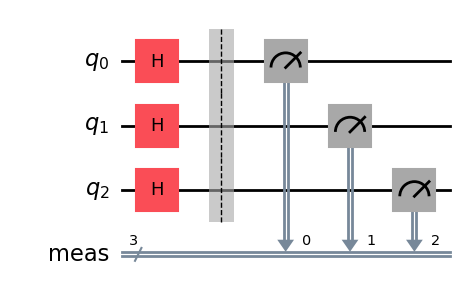

In [31]:
qc.draw('mpl')

Then we have to run the simulation. We have to run the simulation many times to have good results. In fact, each run of a quantum circuit gives only **one random outcome** (e.g., `0` or `1`). Because quantum results are **probabilistic**, we must repeat the circuit many times (called *shots*) to estimate the **true probabilities** of each outcome (More runs = more accurate results). In our case we will run the simulation 1024 times.

In [32]:
results = run_simulation(qc, shots=1024)
print(results)

{'011': 103, '110': 148, '001': 115, '000': 136, '101': 140, '010': 152, '111': 119, '100': 111}


The result is a dictionnary with key an output of a simulation and value how many time this value appeared during all the 1024 simulations. But this isn't a good way to visualise it. It would be more representative with a plot. Fortunately qiskit has a way to do it with 'plot_histogram'.

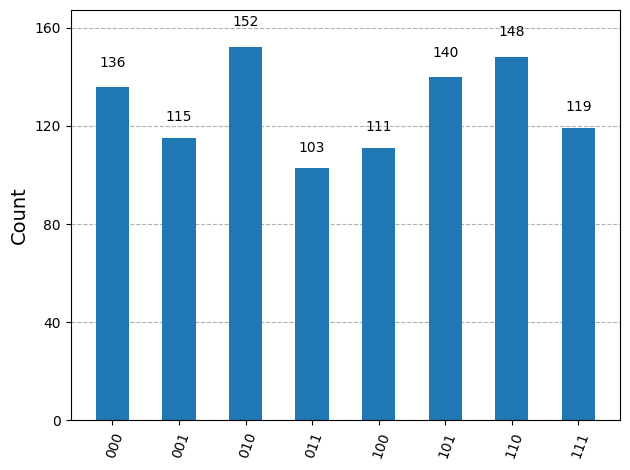

In [33]:
plot_histogram(results)

We can see that the outcome is truly random making each 3 bits numbers equally likely. We really have implemented a quantum random generator.

## VI) Crack RSA with Quantum Computers

## Shor Algorithm

---

### Objective

Shor’s algorithm allows us to **factor an integer $n$**, i.e. to find its prime factors $p$ and $q$ such that:

$$
n = p \cdot q
$$

This directly breaks RSA because it lets us compute $\varphi(n)$.

---

### Step 1: Choose a random number $a$

Choose $a$ such that $1 < a < n$

- If $\gcd(a, n) \neq 1$, then we have already found a **non-trivial factor** of $n$: factorization is done, and we stop here.  
> Note: for RSA, since $n = p \cdot q$, $\gcd(a, n) \neq 1$ directly gives $p$ or $q$.  
- If $\gcd(a, n) = 1$, proceed to the next step.

---

### Step 2: Find the order $r$ of $a$ modulo $n$

- If $\gcd(a, n) = 1$, then $a$ is **invertible modulo $n$** and there exists an integer $k$ such that:  
    $$
    a^k \equiv 1 \bmod n
    $$
- We denote $r$ as the order of $a$ modulo $n$. It is the smallest integer $k$ such that:
    $$
    a^k \equiv 1 \bmod n
    $$
- Once the order $r$ is found, if it is odd, go back to Step 1. Otherwise, continue to the next step.
> Note: we search for $r$ and not a multiple because:
> - if $k$ is even, $a^{r_{multiple}} = a^{kr/2} \equiv 1 \bmod n$, which gives trivial GCDs (1 or n)
> - if $k$ is odd, $a^{r_{multiple}} \equiv a^{r/2} \bmod n$, so we gain nothing

---

### Step 3: Compute the factors of $n$

- If the order $r$ of $a$ is even, then we can write:

   $$(a^{r/2} - 1)(a^{r/2} + 1) \equiv 0 \bmod n$$

  *Proof:* Since $a^r \equiv 1 \bmod n$ and $a^r - 1 = (a^{r/2} - 1)(a^{r/2} + 1)$, the product is zero modulo $n$.

- If $a^{r/2} \pm 1 \not\equiv 0 \bmod n$, then the non-trivial factors of $n$ are given by:  
  $$
  p = \gcd(a^{r/2} - 1, n), \quad
  q = \gcd(a^{r/2} + 1, n)
  $$

  Otherwise, go back to Step 1.

---

### Algorithm summary:
- Step 1: Choose a random number $a$ such that $1 < a < n$.
- Step 2: Find the order $r$ of $a$ modulo $n$.
- Step 3: Compute the prime factors:
  $$
  p = \gcd(a^{r/2} - 1, n), \quad
  q = \gcd(a^{r/2} + 1, n)
  $$
---

### Note: The role of the quantum computer

- The hard part is to **find $r$ efficiently**.  
- On a classical computer, you’d need to test many powers → too slow.  
- The quantum computer uses:  
  1. **Superposition**: all possible $k$ values are put in a quantum state.  
  2. **Function $f(k) = a^k \bmod n$** applied in parallel.  
  3. **Quantum Fourier Transform (QFT)**: reveals the period $r$.  
  4. **Measurement**: retrieves $r$ with high probability.  

---

### Proof of correctness

1. **Existence of $r$**: every function $f(k) = a^k \bmod n$ is periodic modulo $p$ and $q$ if $\gcd(a, n) = 1$.  
2. **Factorization via gcd**: if $r$ is even and $a^{r/2} \not\equiv -1$, then $(a^{r/2}-1)(a^{r/2}+1) \equiv 0 \bmod n$, and the gcd extracts a prime factor.  
3. **Probability of success**: at least half of all possible $a$ lead to success → repeating a few times almost always works.  
4. **Completeness**: for RSA, finding one factor is enough to recover the other.

---

### Concrete example

Take $n = 15 = 3 \cdot 5$ and $a = 2$:

1. $\gcd(2,15)=1$, so continue.  
2. Function: $f(k) = 2^k \bmod 15$  
3. Order: $r = 4$ (first $k$ with $2^k \equiv 1 \mod 15$)  
4. Factorization: $2^4 - 1 = 15 = (2^2-1)(2^2+1) = 3 \cdot 5$  
5. GCD computation: $\gcd(3,15)=3$, $\gcd(5,15)=5$ → the prime factors are found.  

> Everything works perfectly.

---


Pretty easy right ? But you are far from being done because implementing it with qiskit is hard but we will go through it step by step. Here is the generic circuit of the algorithm.

![alt text](images/shor_circuit.jpg)

### Step-by-Step Tutorial: Implementing Shor's Algorithm in Qiskit

#### Step 1: Define the qubits

Shor's algorithm uses three types of qubits:

1. **Control qubits**:  
   - These qubits encode the exponent `x` in the modular exponentiation $a^x \mod N$.  
   - We will apply **Hadamard gates** to put them into **superposition**, so that all possible values of `x` are considered at once.

2. **Target qubits**:  
   - These qubits hold the result of the modular exponentiation $a^x \mod N$.  
   - Initially, they are set to represent the number `1` (or $\ket{1}$) since $a^0 \mod N = 1$.

3. **Classical counting qubits**:  
   - Used to **measure the phase** after quantum operations.  
   - The number of counting qubits affects the **precision** of the estimated period.

**Implementation detail** : So first step is to know how many qubits we have to use. To do that we have to know how many qubits are needed to write our number n in binary. This will be the number of target qubits. For enough precision of estimation we take twice the number of target qubits for our control qubits. Since at the end we measure our control qubits we have to have as many classical counting bits.


--- 

#### Step 2: Put Control Qubits in Superposition

Apply a **Hadamard gate** to each control qubit:

- This creates a **superposition** of all possible $x$ values.
- Each control qubit now represents **all states 0 and 1 at the same time**.
- This is necessary because **Shor's algorithm evaluates $a^x \mod N$ for all $x$ simultaneously**. This is what makes the algorithm so powerful.


---

#### Step 3: Define Modular Multiplication as a Unitary

We need a **unitary matrix** $U$ such that:

$$
U \, |y\rangle = |a \cdot y \bmod N\rangle
$$

- In **Qiskit**, we can build it using `UnitaryGate`.
- This will be applied **controlled by the control qubits**, meaning it only acts on the target qubits if the control qubit is in the $\ket{1}$ state. You will see why it is important in the next step.

We have implemented for you this matrix.

In [1]:
def mod_gate(a, N):
    """
    Modular multiplication gate from permutation matrix.
    N is the number to factorise and a is the coprime we are going to use in a^x mod n
    """
    n = floor(log(N - 1, 2)) + 1
    U = np.full((2**n, 2**n), 0)
    for x in range(N):
        U[a * x % N][x] = 1
    for x in range(N, 2**n):
        U[x][x] = 1
    G = UnitaryGate(U)
    G.name = f"U_{a}mod{N}"
    return G

---

#### Step 4: Apply Controlled Modular Exponentiation (Quantum Phase Estimation)

For each control qubit $k$:

- Apply $U^{2^k}$ **controlled** on that qubit.
- This encodes the **phase corresponding to the eigenvalue** of $U$ in the control qubits.
- This is the core of **Quantum Phase Estimation (QPE)**.
- The measured phase will allow us to **extract the period $r$** of $a^x \mod N$.

**Why this is important and how it works:**

1. **Quantum Phase Estimation (QPE) relies on controlled operations:**  
   - In Shor’s algorithm, we want to estimate the **phase $\phi$ corresponding to the eigenvalue** of the unitary operator $U$, the matrix we defined above via modular multiplication.  
   - An eigenvector $|u\rangle$ of $U$ satisfies $U |u\rangle = e^{2\pi i \phi} |u\rangle$, where $\phi$ contains information about the period $r$ of $a^x \mod N$. We will explain later how we can retrieve this information.
   - By applying $U$ **controlled on the control qubits**, the phase $\phi$ is **encoded in the amplitudes** of the control qubits. It is important because we can only measure the amplitude and not the phase !

2. **Exponentiation via powers of two:**  
   - Each control qubit represents a **different power of 2** in the exponent $x$ of $a^x \mod N$.  
   - Applying the modular multiplication **controlled** ensures that the target qubits are affected **only when that qubit contributes** to $x$. Basically if that qubit is 1 in the binary representation of x. 
   - Mathematically, this implements $U^{2^k}$ for the $k$-th control qubit.

3. **Preserves superposition:**  
   - Control qubits are in **superposition** of all $x$ values.  
   - Using controlled $U^{2^k}$ gates (see circuit above) allows the target qubits to hold **all possible $a^x \mod N$ values simultaneously**, creating quantum parallelism.  
   - This is what gives Shor's algorithm its exponential speedup over classical factoring.

**In simple terms:**  

- The eigenvalue $e^{2\pi i \phi}$ of $U$ encodes the **repeating pattern (period) of $a^x \mod N$**.  
- By using controlled gates, we transfer this **hidden periodicity** from the target qubits into the control qubits, where it can be measured and used to compute the factors of $N$.

Follow this Step-by-Step to apply Controlled Modular Exponentiation :

1. **Create the modular multiplication gate**  (See step before)
     
2. **Loop over each control qubit**  
   - Each control qubit corresponds to a different **power of 2** in the exponent $x$ of $a^x \bmod N$.  
   - The first control qubit represents the least significant bit, the second represents the next power of 2, and so on.

3. **Apply powers of the unitary and make it controlled**  
   - Raise $U$ to the power $2^k$, where $k$ is the index of the control qubit with power() and make the gate controlled with control(). Don't forget to get the result because it's the gate we are going to work with.

4. **Compose into the circuit**  
   - Sequentially apply these controlled unitaries with compose() to build the full controlled modular exponentiation. The list of qubit correspond to the control qubit itself and the list of the targets qubits it's acting on. (Don't forget to force the target into a list). The value inplace must be True as well.
   - Insert barriers (with barrier()) between steps if needed to separate stages visually in the circuit.

5. **Return the modified circuit**


In [90]:
def QPE(control, target, circuit, a, N):
    """
    control is the list of the controlled qubits
    target is the list of the target qubits
    circuit corresponds to the circuit representing Shor
    a is the coprime
    N is the number to factorise
    """
    U = mod_gate(a, N)
    for k, qubit in enumerate(control):
        U_controlled = U.power(2**k).control()
        circuit.compose(U_controlled, qubits=[qubit] + list(target), inplace=True)
        circuit.barrier()
    return circuit

---

#### Step 5: Apply Quantum Fourier Transform (QFT)

- The **QFT** (Quantum Fourier Transform) extracts the **phase encoded** in the control qubits into a **computational basis state**.  
- After applying QFT†, **measuring the control qubits** gives a **binary approximation** of the phase:

$$
\phi = \frac{s}{r}
$$

**Understanding $s$ and the fraction $\phi = s/r$:**

1. **What $s$ represents:**  
   - In Shor's algorithm, $r$ is the **period** of the function $f(x) = a^x \mod N$.  
   - The unitary $U$ for modular multiplication has **eigenvalues** of the form:

   $$
   e^{2\pi i s / r}, \quad s = 0, 1, \dots, r-1
   $$

   - The integer $s$ indexes the **different eigenvalues** of $U$ corresponding to the period $r$.  
   - Each $s$ is associated with a possible outcome of Quantum Phase Estimation (QPE).

2. **Why the fraction $\phi = s/r$ appears:**  
   - The phase of each eigenvalue is always a **rational number** because we used Shor's modular multiplication unitary. That's why the eigenvalue $\phi$ is represented with form:

   $$
   \phi = \frac{s}{r}
   $$

   - QPE measures an approximation of this phase as:

   $$
   \frac{m}{2^n} \approx \phi
   $$

   - Where:  
     - $m$ is the **integer value** obtained from measuring the $n$ control qubits (in decimal).  
     - $n$ is the **number of control qubits**, which determines the **precision** of the phase estimation.  

   - Using **continued fractions** on $m/2^n$, we can recover the **denominator $r$**, i.e., the period of $a^x \mod N$.

Based on the image below that performs qft on 4 qubits, implement the quantum fourier transform for n qubits

![alt text](images/prep_qft_circuit.png)

We have already seen what the H gate is but the blue line corresponds to the control phase gate. See how to implement it [here](https://quantum.cloud.ibm.com/docs/en/api/qiskit/1.0/qiskit.circuit.library.CPhaseGate). Specifically look at the cp() method.


In [91]:
def QFT(num_control, control, circuit):
    """
    num_control is the number of control qubits and with the representation above the number of qubits to perform the QFT
    control is the ordered list of the control qubits/qubits to perform QFT on
    circuit is the circuit on which to implement the qft.
    When applying the gates don't forget to use the control list instead of just putting the index.
    The theta angle decays with rate pi/2**x starting from pi/2. The angle must be used with pi not degrees. You can np.pi for pi.
    """
    for j in range(num_control):
        circuit.h(control[num_control-j-1])
        for k in range(j+1, num_control):
            # Apply controlled phase rotation
            circuit.cp(np.pi/2**(k-j), control[num_control-k-1], control[num_control-1-j])
        circuit.barrier()
    # Swap qubits to reverse order
    for i in range(num_control//2):
        circuit.swap(control[i], control[num_control-i-1])
    circuit.barrier()
    return circuit

--- 

#### Step 6: Measure Control Qubits

- Measuring the control qubits gives a **binary number**, which corresponds to a **phase estimate**.  
- This estimated phase can then be used to compute the **period $r$** via **continued fractions** as seen before.


---

#### Step 7: Post-Processing to Find Factors

1. **Convert the measured value to a phase:**

$$
\text{phase} = \frac{\text{measured\_value}}{2^{\text{num\_control}}}
$$

2. **Approximate the fraction** by limiting the denominator to be $N$ maximum and find the denominator $r$.
   - In Shor's algorithm, the **period $r$** of the function $f(x) = a^x \mod N$ must satisfy:
    $$
    a^r \equiv 1 \ (\text{mod } N)
    $$
    - The period $r$ is therefore **at most $N$**, since it cannot be larger than the number we are factoring.
  
3. **Use $r$ to compute potential factors:**

$$
\text{factor}_1 = \gcd(a^{r/2} - 1, N), \quad
\text{factor}_2 = \gcd(a^{r/2} + 1, N)
$$

4. **Verify that the factors are non-trivial**, i.e., they are not 1 or $N$.

Now create a function that estimates the period (use the fraction class and don't forget to calculate the phase first)

In [92]:
def estimate_period(N, value, nb_precision_qubits):
    """
    N is the number to factorise
    value is the measured_value
    nb_precision_qubits is the number of control qubits
    """
    phase = value / 2**nb_precision_qubits 
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    return r

Now create a function to calculate the factors with the period

In [93]:
def calculate_factors(a, r, N):
    """
    a is the coprime
    r is the period found
    N is the number to factorise
    Return the factors as a list if you are able to find them else return None
    """
    #check if r is even
    if r % 2 == 0:
    # Calculate potential factors
        factor1 = gcd(pow(a, r//2) - 1, N)
        factor2 = gcd(pow(a, r//2) + 1, N)
        if factor1 not in [1, N] or factor2 not in [1, N]:
            return [factor1, factor2]
    return None

Now that we have implemented all the helping functions. Implement the algorithm.

First let's initialise the whole circuit (step 1 to 6). 
We have already given you the list of the control qubits, target qubits and output qubits. 
Don't forget to measure the qubits but this time we can't use measure_all because we don't care about the value of the target qubits. So we have to use measure().

In [94]:
def initialize_circuit(a, N, num_target, num_control):
    """
    a is the coprime
    N is the number to factorise
    num_target is the number of target qubits
    num_control is the number of control qubits
    """
    # Initialize the circuit
    control = QuantumRegister(num_control, name="C")
    target = QuantumRegister(num_target, name="T")
    output = ClassicalRegister(num_control, name="out")
    circuit = QuantumCircuit(control, target, output)
    circuit.x(target[0])
    circuit.barrier()
    for qubit in control:
        circuit.h(qubit)
    circuit.barrier()
    circuit = QPE(control, target, circuit, a, N)
    circuit = QFT(num_control, control, circuit)
    circuit.measure(control, output)
    return circuit

We are providing you a function to print the factors : 

In [95]:
def print_factors(factors, N): 
    factor1 = factors[0]
    factor2 = factors[1]
    if factor1 in [1,N] :
        print(f"Found the 2 factors : {factor2} and {N//factor2}")
    elif factor2 in [1,N] :
        print(f"Found the 2 factors : {factor1} and {N//factor1}")
    else :
        print(f"Found the 2 factors : {factor1} and {factor2}")

Now let's implement the whole algorithm

In [98]:
def shor(a, N):
    # Precompute to see if a and N are coprime
    if gcd(a, N) > 1:
        print(f"Error: gcd({a},{N}) > 1")
        return None
    # Number of qubits
    #Calculate the number of target qubits and control qubits
    num_target = floor(log(N - 1, 2)) + 1  # for modular exponentiation operators
    num_control = 2 * num_target  # for enough precision of estimation
    print("Initializing the circuit...")
    #Initialize the circuit (step 1-6)
    circuit = initialize_circuit(a, N, num_target, num_control)
    print("Circuit initialized")
    print("Simulating the circuit...")
    #simulate the algorithm 
    counts = run_simulation(circuit)
    print("Simulations done")
    #This will allow us to have the sorted list of the possible outputs in decimal.
    decimal_values = sorted([int(bitstr, 2) for bitstr in counts.keys()])
    #Try to retrieve the period and the factors for each value. If the value is 0 then continue.
    for value in decimal_values:
        if value == 0:
            continue
        r = estimate_period(N, value, num_control)
        print(f"Estimated period r = {r} from value {value}")
        print("Trying to calculate factors...")
        factors = calculate_factors(a, r, N)
        if factors:
            print("Factors found!")
            print_factors(factors, N)
            return
        print("Failed to calculate factors with this r, trying next value...")
    print("Failed to find factors.")
    return

Now let's try it with a=2 and N=15
Here is what the final circuit should look like : 
![alt-text](images/shor215.png)

In [99]:
a = 2
N = 15
shor(a, N)

Initializing the circuit...
Circuit initialized
Simulating the circuit...
Simulations done
Estimated period r = 4 from value 64
Trying to calculate factors...
Factors found!
Found the 2 factors : 3 and 5


## VII) Is security of our data compromised ?

### Quantum Computers are yet not powerful enough

Although Shor’s algorithm provides a polynomial-time method for integer factorization, its practical application is severely limited by the current state of quantum hardware. Experimental demonstrations have so far only managed to factor very small numbers, with the most reliable implementations handling integers such as **15** and **21**.  

**Guess what?** *YOU have implemented a circuit that factors 15!* So you officially belong to the elite ranks of quantum computing pioneers :).

These results validate the algorithm but highlight the vast gap between theoretical capability and cryptographically relevant problem sizes.

Estimates for breaking a **2048-bit RSA modulus** remain far beyond present technology. Factoring such a number is projected to require approximately **20 million physical qubits** when error correction overhead is considered. Even with algorithmic optimizations, the requirement is unlikely to fall below **one million physical qubits**. By contrast, the most advanced hardware currently available contains just over **1,000 qubits** (such as IBM’s *Condor* processor with **1,121 qubits**), underscoring the enormous gap between experimental capability and the resources required to compromise RSA in practice.  

The circuit depth of Shor’s algorithm scales quadratically with the key size, and at this scale, execution would demand **trillions of sequential quantum gate operations**—orders of magnitude beyond the **coherence times of existing devices** (IBM's best hardware has a coherence time of **400 microseconds**). In addition, the total energy expenditure for such a computation has been estimated in the **tens of megawatt-hours**, comparable to the continuous operation of a small industrial facility.

In summary, while RSA is theoretically vulnerable to quantum factorization, the hardware required to execute such an attack does not yet exist. Present-day quantum computers remain **millions of qubits** and several technological breakthroughs away from posing a realistic threat to widely used cryptographic key sizes.


### Classical methods such as Elliptic Curve Cryptography cannot be crack by quantum computers (yet)

#### Elliptic Curve Cryptography (ECC)

ECC is based on the algebraic structure of **elliptic curves over finite fields**. The main idea is that while it is easy to perform certain operations (point addition and scalar multiplication), it is **computationally hard to invert them**, a problem known as the **elliptic curve discrete logarithm problem (ECDLP)**.

A typical elliptic curve over a prime field $\mathbb{F}_p$ is defined as:

$$
y^2 \equiv x^3 + ax + b \pmod{p}
$$

with the condition 

$$
4a^3 + 27b^2 \not\equiv 0 \pmod{p}
$$

to avoid singularities.

A **prime field** $\mathbb{F}_p$ is the set of integers modulo a prime number $p$:

$$
\mathbb{F}_p = \{ 0, 1, 2, \dots, p-1 \}
$$
Let $p = 7$. Then:
$$
\mathbb{F}_7 = \{0, 1, 2, 3, 4, 5, 6\}
$$

---

#### Steps to Use ECC

1. **Define the Curve and Field**  
   Choose a prime $p$ and curve parameters $a, b$ that satisfy the curve equation and are secure.

2. **Select a Base Point $G$**  
   A predefined point $G = (x, y)$ on the curve is selected, called the **generator point**.

3. **Key Generation**

    - **Private Key**: The private key is a randomly chosen integer $d$ such that $1 \leq d \leq n-1$, where $n$ is the **order of the base point** $G$. The order $n$ is the smallest positive integer such that $n \cdot G = \mathcal{O}$, where $\mathcal{O}$ is the **point at infinity**, acting as the “zero” of the elliptic curve group. You can think of the elliptic curve like a **circular track**: starting at $G$, if you keep running $d$ laps (adding $G$ repeatedly), you eventually return to the starting line after $n$ laps. The private key $d$ is like the **number of laps you choose to run**. Even if someone sees your final position $Q$ on the track, figuring out exactly how many laps you ran (the value of $d$) is extremely hard — this is what keeps ECC secure.
      
    - **Public Key**: The public key is a point $Q$ on the curve, computed as $$ Q = d \cdot G $$ using **scalar multiplication**, which is repeated addition of the point $G$ to itself $d$ times. For example, $2 \cdot G = G + G$, $3 \cdot G = G + G + G$, and so on. This is the core operation: repeatedly adding a point to itself efficiently using double-and-add. Scalar multiplication is computationally easy in the forward direction, but given $Q$ and $G$, it is extremely hard to determine $d$ — this is the **elliptic curve discrete logarithm problem (ECDLP)**. This asymmetry is what makes ECC secure: the private key $d$ allows you to generate the public key $Q$, but deriving $d$ from $Q$ without knowing it is computationally infeasible.


In [34]:
def point_add(P, Q):
    # Add two points P and Q on the elliptic curve

    if P is None:
        return Q  # If P is the point at infinity, return Q
    if Q is None:
        return P  # If Q is the point at infinity, return P

    x1, y1 = P
    x2, y2 = Q

    if P == Q:
        # Point doubling case
        if y1 == 0:
            return None  # Tangent is vertical, result is point at infinity
        # Slope of tangent line at P
        m = (3*x1**2 + a) * pow(2*y1, -1, p) % p
    else:
        if x1 == x2:
            return None  # Vertical line, result is point at infinity
        # Slope of line connecting P and Q
        m = (y2 - y1) * pow(x2 - x1, -1, p) % p

    # Compute the resulting point coordinates
    x3 = (m**2 - x1 - x2) % p
    y3 = (m*(x1 - x3) - y1) % p

    return (x3, y3)  # Return the sum point

def scalar_mult(k, P):
    # Multiply point P by integer k using double-and-add method

    R = None  # Initialize result as point at infinity
    addend = P  # Start with the initial point

    while k:
        if k & 1:
            R = point_add(R, addend)  # Add current addend if lowest bit of k is 1
        addend = point_add(addend, addend)  # Double the point for next bit
        k >>= 1  # Shift k to process next bit

    return R  # Return the resulting point k*P


In [35]:
# --- Step 1: Define the Curve and Field ---
# Curve: y^2 = x^3 + ax + b over F_p
p = 97         # prime field
a = 2
b = 3

# --- Step 2: Select a Base Point G ---
G = (3, 6)     # generator point

# --- Step 3: Key Generation ---

# Private key: random integer d
n = 5  # Example small order for demonstration
d = random.randint(1, n-1)
print("Private key d =", d)

# Public key: Q = d * G
Q = scalar_mult(d, G)
print("Public key Q =", Q)


Private key d = 3
Public key Q = (80, 87)


Elliptic Curve Cryptography (ECC) relies on the difficulty of finding an integer $k$ given a point $P$ and $Q = kP$ on the curve, a problem that is currently intractable for both classical and quantum computers with available resources. Even optimistic projections for quantum hardware capable of breaking RSA-2048 would be insufficient to compromise standard ECC key sizes, such as 256-bit or 384-bit curves, due to the exponential growth of the problem in terms of required qubits and quantum gate operations.  

While quantum algorithms like Shor’s algorithm can theoretically solve discrete logarithms, implementing them for elliptic curves at cryptographically relevant key sizes would require **millions of logical qubits and trillions of gate operations**, far beyond the capabilities of existing or near-term quantum hardware. Consequently, ECC remains a **practical and quantum-resistant choice** for secure communications today, providing strong security with relatively small key sizes compared to classical schemes like RSA, and is often considered a preferred alternative to RSA until sufficiently large-scale fault-tolerant quantum computers become available.

### Quantum Cryptography based on superposition and entanglement (Bell's Pairs)

Try to remember the 2 controversial properties of quantum mechanics entanglement and superposition. By combining superposition and entanglement, we can create entirely new ways to encode and transmit information securely, forming the basis for next-generation cryptography that is much safer than classical methods. Do you have an idea on how to do it ? Not yet ? Let me break it down for you.

Imagine that the information we are sharing is in a superposition of states, meaning it can hold multiple possibilities at the same time. If we then entangle this information with another particle, we create a strong link between them. Entanglement allows for secure communication because if anyone tries to measure one of the entangled particles, the connection is disturbed, instantly revealing the presence of an eavesdropper.

We are going to see both superpostion and entanglement in action in what we call Bell's Pairs. A **Bell pair** is a pair of qubits that are prepared in a specific **maximally entangled state**. In a Bell pair, the qubits are so strongly correlated that the measurement of one qubit immediately determines the state of the other, regardless of the distance between them. This entanglement is a purely quantum phenomenon that has no classical equivalent.

To create a Bell pair, we typically perform two operations on two qubits initialized in the state $|00\rangle$:

1. Apply a **Hadamard gate** $H$ to the first qubit. This puts it into a superposition:

2. Apply a **CNOT (controlled-NOT) gate** with the first qubit as the control and the second qubit as the target. This entangles the two qubits in the resulting state :

$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

This makes the states $|00\rangle$ and $|11\rangle$ equally likely.

Implement a circuit to create a bell's pair (don't forget to measure the final state)

In [36]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

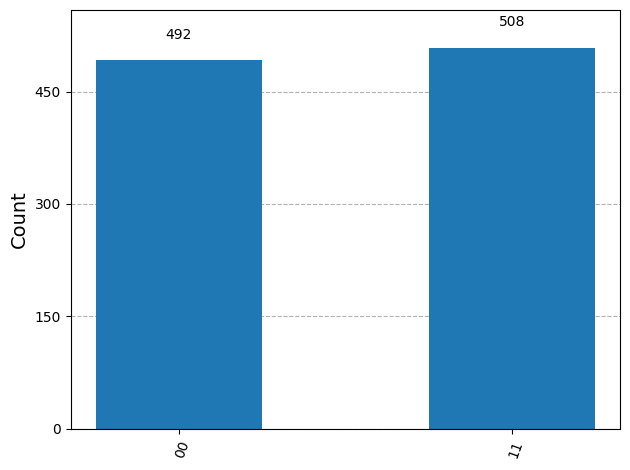

In [37]:
counts = run_quantum_circuit(qc, 1000)
plot_histogram(counts)